In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [4]:
df = pd.read_csv('data/klabin_historical.csv')

In [5]:
data = df[['Date', 'Close']]
data.head()

,Date,Close
0,2008-01-02 00:00:00-02:00,0.749389
1,2008-01-03 00:00:00-02:00,0.745956
2,2008-01-04 00:00:00-02:00,0.721930
3,2008-01-07 00:00:00-02:00,0.734515
4,2008-01-08 00:00:00-02:00,0.716209


In [6]:
# settando o cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

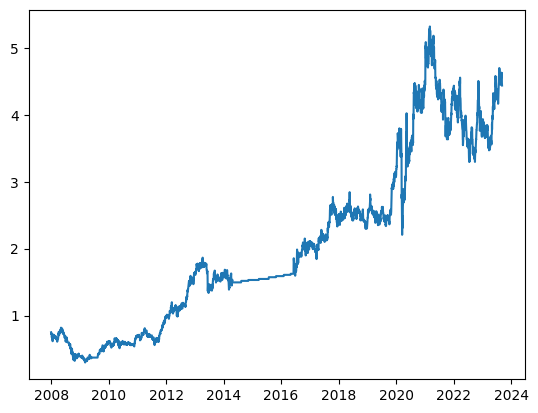

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data.loc[:, 'Date'], data.loc[:, 'Close']);

In [8]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2008-01-11 00:00:00-02:00,0.671589,0.687607,0.703625,0.716209,0.734515,0.721930,0.745956,0.749389
2008-01-14 00:00:00-02:00,0.701336,0.671589,0.687607,0.703625,0.716209,0.734515,0.721930,0.745956
2008-01-15 00:00:00-02:00,0.684175,0.701336,0.671589,0.687607,0.703625,0.716209,0.734515,0.721930
2008-01-16 00:00:00-02:00,0.692183,0.684175,0.701336,0.671589,0.687607,0.703625,0.716209,0.734515
2008-01-17 00:00:00-02:00,0.657860,0.692183,0.684175,0.701336,0.671589,0.687607,0.703625,0.716209


In [9]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[0.67158949, 0.68760699, 0.70362467, ..., 0.72193015, 0.74595642,
        0.74938869],
       [0.70133615, 0.67158949, 0.68760699, ..., 0.73451549, 0.72193015,
        0.74595642],
       [0.68417478, 0.70133615, 0.67158949, ..., 0.71620947, 0.73451549,
        0.72193015],
       ...,
       [4.61000013, 4.63000011, 4.5999999 , ..., 4.63000011, 4.57999992,
        4.53000021],
       [4.48000002, 4.61000013, 4.63000011, ..., 4.61000013, 4.63000011,
        4.57999992],
       [4.44000006, 4.48000002, 4.61000013, ..., 4.59000015, 4.61000013,
        4.63000011]])

In [10]:
split_index = int(len(shifted_df_as_np) * 0.85)

split_index

3304

In [11]:
split_index

3304

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np_train = scaler.fit_transform(shifted_df_as_np[:split_index])
shifted_df_as_np_test = scaler.transform(shifted_df_as_np[split_index:])

In [13]:
X_train = shifted_df_as_np_train[:, 1:]
y_train = shifted_df_as_np_train[:, 0]

X_test = shifted_df_as_np_test[:, 1:]
y_test = shifted_df_as_np_test[:, 0]


X_train.shape, y_train.shape

((3304, 7), (3304,))

In [14]:
X_train = dc(np.flip(X_train, axis=1))
X_test = dc(np.flip(X_test, axis=1))

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3304, 7), (584, 7), (3304,), (584,))

In [16]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Aqui o shape significa: (profundidade: 15489, linhas: 7, colunas: 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3304, 7, 1), (584, 7, 1), (3304, 1), (584, 1))

In [17]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3304, 7, 1]),
 torch.Size([584, 7, 1]),
 torch.Size([3304, 1]),
 torch.Size([584, 1]))

In [18]:
# Criando o objeto Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [19]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([4, 7, 1]) torch.Size([4, 1])


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 32, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index + 1 % 100 == 0:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [24]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.115
***************************************************

Epoch: 2

Val Loss: 0.125
***************************************************

Epoch: 3

Val Loss: 0.070
***************************************************

Epoch: 4

Val Loss: 0.033
***************************************************

Epoch: 5

Val Loss: 0.019
***************************************************

Epoch: 6

Val Loss: 0.011
***************************************************

Epoch: 7

Val Loss: 0.009
***************************************************

Epoch: 8

Val Loss: 0.007
***************************************************

Epoch: 9

Val Loss: 0.006
***************************************************

Epoch: 10

Val Loss: 0.005
***************************************************



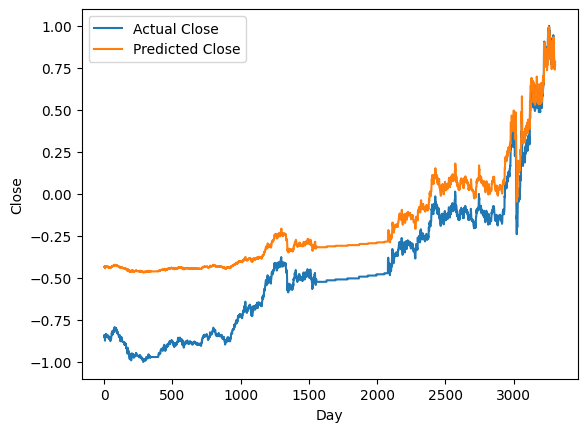

In [25]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [26]:
train_predictions = predicted.flatten()

In [27]:
train_predictions

array([-0.43426755, -0.4351936 , -0.43147594, ...,  0.78929293,
        0.7820805 ,  0.76877624], dtype=float32)

In [47]:
dummies = np.zeros((X_train.shape[0], lookback+1))

In [48]:
dummies[:, 0] = train_predictions

In [30]:
dummies.shape

(3304, 8)

In [31]:
dummies = scaler.inverse_transform(dummies)

In [32]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([1.71898158, 1.71665471, 1.72599606, ..., 4.79341861, 4.77529588,
       4.74186637])

In [33]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([0.67158951, 0.70133621, 0.68417485, ..., 4.77759168, 4.76893716,
       4.77759168])

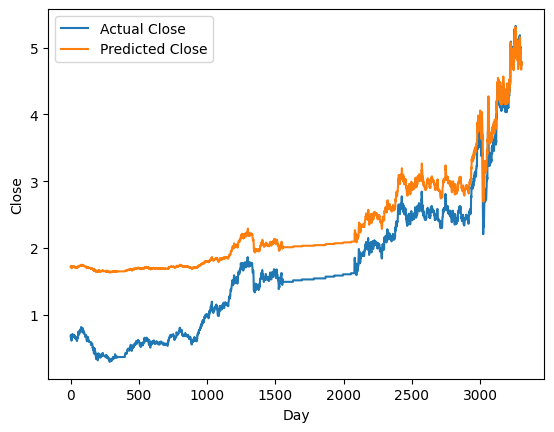

In [34]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [45]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions[:10]

array([4.76426843, 4.82019121, 4.72918727, 4.57028133, 4.53947381,
       4.58968412, 4.56565453, 4.56074467, 4.43632216, 4.46296042])

In [36]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test[:10]

array([4.82086801, 4.76028204, 4.62180136, 4.55256132, 4.56121539,
       4.54390576, 4.54390576, 4.43139028, 4.43139028, 4.44869992])

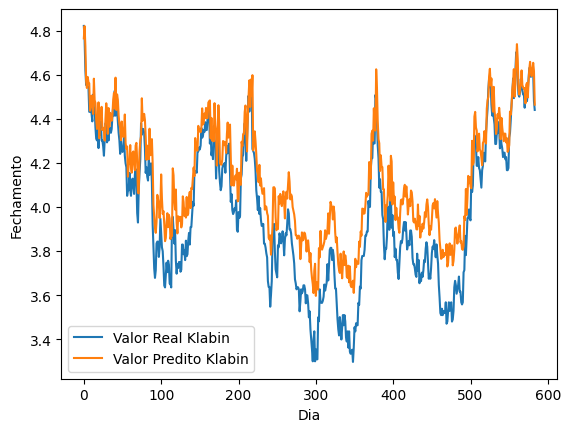

In [37]:
plt.plot(new_y_test, label='Valor Real Klabin')
plt.plot(test_predictions, label='Valor Predito Klabin')
plt.xlabel('Dia')
plt.ylabel('Fechamento')
plt.legend()
plt.show()

In [38]:
X_train.max(dim=2)

torch.return_types.max(
values=tensor([[-0.8201, -0.8215, -0.8311,  ..., -0.8333, -0.8384, -0.8447],
        [-0.8215, -0.8311, -0.8261,  ..., -0.8384, -0.8447, -0.8511],
        [-0.8311, -0.8261, -0.8333,  ..., -0.8447, -0.8511, -0.8393],
        ...,
        [ 0.8760,  0.8037,  0.8002,  ...,  0.7658,  0.7485,  0.7830],
        [ 0.8037,  0.8002,  0.7795,  ...,  0.7485,  0.7830,  0.7830],
        [ 0.8002,  0.7795,  0.7658,  ...,  0.7830,  0.7830,  0.7795]]),
indices=tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]))

In [39]:
X_test.max()

tensor(0.8002)

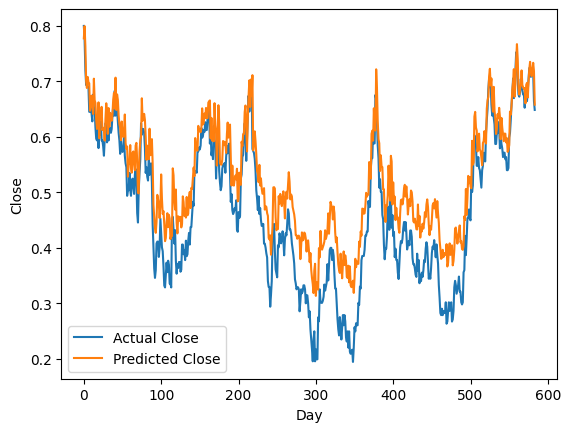

In [40]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()